### ISD Lite Pre-Processing
The following notebook is for the WiDS Cohort 2 Weather Team, and will compile data sets for analysis. If the data has not been aquired, this notebook will download the neccessary data files as "gzip" if they are not already downloaded.

Please review to determine what data is required, and where the downloaded data will be stored.

ISD Lite URL: "ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/2019/"

List of 7 stations for 2019:

    997997-99999-2019.gz
    749179-00392-2019.gz
    724915-23259-2019.gz
    998173-99999-2019.gz
    725930-23233-2019.gz
    745058-23277-2019.gz
    749484-00395-2019.gz

These data sets contain the following 8 items:
1.  Air temperature (degrees Celsius * 10)
2.  Dew point temperature (degrees Celsius * 10)
3.  Sea level pressure (hectopascals)
4.  Wind direction (angular degrees)
5.  Wind speed (meters per second * 10)
6.  Total cloud cover (coded, see format documentation)
7.  One-hour accumulated liquid precipitation (millimeters)
8.  Six-hour accumulated liquid precipitation (millimeters) 


#### Cloud Cover Code 
NOAA Sky Codes detailed description can be read here: ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite

I have combined these NOAA codes and the "okta" symbols as defined on Wikipedia.

Code  | Description | symbol
:-:|-:|:-:|
-9999 | MISSING VALUE |
0| None, SKC or CLR|<span style="font-size:1.5em;">○</span>
1|One okta - 1/10 or less but not zero|<span style="font-size:1.5em;">⌽</span>
2|Two oktas - 2/10 - 3/10, or FEW|<span style="font-size:3em;">◔</span>
3|Three oktas - 4/10|
4|Four oktas - 5/10, or SCT|<span style="font-size:1.5em;">◑</span>
5|Five oktas - 6/10 | 
6|Six oktas - 7/10 - 8/10|<span style="font-size:3em;">◕</span>
7|Seven oktas - 9/10 or more but not 10/10, or BKN|
8|Eight oktas - 10/10, or OVC|<span style="font-size:1.5em;">●</span>
9|Sky obscured, or cloud amount cannot be estimated|<span style="font-size:2.5em;">⊗</span>
10|Partial obscuration|
11|Thin scattered|
12|Scattered|
13|Dark scattered|
14|Thin broken|
15|Broken|
16|Dark broken|
17|Thin overcast|
18|Overcast|
19|Dark overcast|

#### Symbols Chart
Wikipedia provided this general discription

Symbol | Unicode | Alt code | Name | Resembles
:-:|-:|-:|-:|-:|
○|U+25CB|9675|Large Circle|0 okta
⌽|U+233D|021|Apl Functional Symbol Circle Stile|1 okta
◔|U+25D4|9684|Circle with upper right quadrant black|2 oktas
◑|U+25D1|9681|Circle with right half black|4 oktas
◕|U+25D5|9685|Circle with all but upper left quadrant black|6 oktas
●|U+25CF|9679|Black Circle|8 oktas
⊗|U+2297|2297|Circled Times	Sky obstructed|
 

### Step (1): Data Acquisition Settings and Required Modules:
Check these settings on your system for where data files will be stored, the FTP URL used, and a list of stations to acquire.

If you are using Anaconda 3, these modules should already be installed. If you need specific direction on installation of packages, let me know.


In [26]:
# Specifying where the data is stored, relative to this notebook's location
data_dir = "./data/"  
# url NOAA metadata: https://www.ncdc.noaa.gov/isd/data-access
# ftp url sources
ftp = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/2019/'
# list of NOAA stations, acomposite of USAF-WBAN-Year
stationsList =['724915-23259-2019', '725930-23233-2019', '745058-23277-2019', '749179-00392-2019', '749484-00395-2019', '997997-99999-2019', '998173-99999-2019']
stationsListWithPressure =['724915-23259-2019', '725930-23233-2019', '745058-23277-2019', '997997-99999-2019', '998173-99999-2019']

#missing pressure data for both Airport stations
#   "Sta_749484_00395"
#   "Sta_749179_00392"
### import libraries for downloading url or ftp data
import sys
from os import path, listdir, makedirs

import shutil
import urllib.request as request
from contextlib import closing
from time import sleep
from IPython.display import clear_output, display
from tqdm import tqdm, tqdm_notebook, tqdm_pandas, trange
import pickle as pkl 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
from scipy import stats
import seaborn as sns
#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
 
sns.set_style('darkgrid', {'figure.facecolor':'skyblue'})
plt.style.use('seaborn-whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# confirms the path for data exists or creates it relative to the notebook location
if not path.exists(data_dir):
    makedirs(data_dir )
    

#### Station Data
The list of stations were selected using NCDC interactive online map:

https://gis.ncdc.noaa.gov/maps/ncei/cdo/daily

<img src="./data/MontereyGSSOD_Stations.PNG"    width="400px"  > 

While there are many stations, they may not be operational during the decided duration for 2019. The original selection of about 20 stations was reduced to just 7 stations, and recently to just 5 stations, after discovering that 2 airport based stations did not record pressure, these were dropped as well.  Metadata about stations can be reviewed here:  
- https://www.ncdc.noaa.gov/data-access/land-based-station-data/station-metadata 

As a timeseries, it may help to interpolate both spatially and temporally populating the missing data based on the station distances within the network for the same frequency or interval. Missing data for the interval can be interpolated for the range of time that data is missing. These then our the rules for missing data between stations and time intervals. 
- 1) Data is the Integrated Surface Database hourly summaries by station.
- 2) Stations are identified by the componsite of Air Force identification and the Weather-Bureau-Army-Navy identification within the depicted area for the year 2019.
- 3) Each station will use the same time series, with a frequency of 1 hour.
- 4) Stations with missing data can resolve using bounding mean of the interval values
  - Rule for more than 1 hour or bands of time that are missing
- 5) Alternatively, (not sure how to do this) Stations with missing interval data can be interpolated by creating a surface from all the stations with data
  - Generate a triangulated irregular network (TIN)
  - Then an Irregular Tessalation: Thiessen polygons or Voronoi tessalations 
  - Stations overlayed with the tessalation values use the mean values
  - Following provides a definitive examples for distance calculation using lat/lon: 
  
https://www.movable-type.co.uk/scripts/latlong.html

  - Following provides a REST endpoint for all the known stations: 

https://gis.ncdc.noaa.gov/arcgis/rest/services/cdo/stations/MapServer

<img src="./data/AllStations.png"    width="400px"  > 

### Step (2): Load Station location Data

#### ToDo: add REST call to query and download station data. 

In [27]:
# read station list
monterey_stations = pd.read_pickle('./data/monterey_stations.pkl')
col_sta = ['station_id', 'station_names', 'begin_date', 'end_date', 'state', 'country', 'latitude', 'longitude', 'elevation']
col_to_drop = ['begin_date', 'end_date', 'state', 'country']
monterey_stations.drop(col_to_drop, axis=1, inplace=True)
#
monterey_stations[( monterey_stations['station_id'] == '72491523259') |
                  ( monterey_stations['station_id'] == '72593023233') |
                  ( monterey_stations['station_id'] == '74505823277') |
                  ( monterey_stations['station_id'] == '99799799999') |
                  ( monterey_stations['station_id'] == '99817399999')
                 ]
#missing pressure data for both Airport stations
#   "Sta_749484_00395"
#   "Sta_749179_00392"


,station_id,station_names,latitude,longitude,elevation
0,72491523259,MONTEREY PENINSULA AIRPORT,36.588060,-121.845280,50.29
1,72593023233,SALINAS MUNICIPAL AIRPORT,36.663600,-121.608100,22.56
2,74505823277,WATSONVILLE MUNICIPAL ARPT,36.935800,-121.788600,48.77
5,99799799999,ELKHORN SLOUGH RESERVE,36.816667,-121.733333,3.00
6,99817399999,MOSS LANDING S HARBOR,36.800000,-121.783333,22.00


### Step (3): Method to Load Data Frame Source (dfs)
This will attempt to load from a local file source if it exists, or download from FTP NOAA ISD source. The Download will create the files, and load them on subsequent runs. Updates to for 2019 can easily be loaded by simply deleting the source gzip files. I did not include these data files in GitHub for this reason. After completed, "dfs" is pickled to be read from file if needed.

In [28]:
dfs = {}    
col_fixed_width_names = ['year','month','day','hour','tempC10', 'dewC10', 'preshPa10' ,'windDeg','windMtPs10','skyCode','precip1hr','precip6hr']

def create_dfs ():
    #data_dir = "./data/"  # Specifying where the data is stored
    dfs = {}
    for file in tqdm_notebook(stationsListWithPressure):
        print("-------------")
        gzfile =  file +'.gz'
        if path.exists( data_dir + gzfile ):
            print('found: '  + gzfile) 
        else:
            print('did not find: ' + data_dir + file +'.gz')
            print('attempting to download from ftp')
            with closing(request.urlopen(ftp + file + '.gz')) as r:
                with open(data_dir + file + '.gz', 'wb') as f:
                    shutil.copyfileobj(r, f)
        if  path.exists( data_dir + gzfile ):
            # Extract file name without .csv extension
            file_ref =  'Sta_' + (file[0:-5].lower()).replace('-','_')  # casting string to lowercase
            print(f"Generating {file_ref} DataFrame...")
            _df = pd.read_fwf(filepath_or_buffer=data_dir+gzfile , compression='gzip' , header=None, names= col_fixed_width_names)
            #_df = pd.read_csv(data_dir+file) 
            # Summarize the contents of the dataframe
            #display(_df.describe(include='all'))  # Using `display` to prettify output
            
            display(_df.info())
            print(f"\t {file_ref} shape: {_df.shape}")
            print("-------------")
            # Storing each dataframe in a dictionary, for convinent storage
            dfs[file_ref] = _df 
            # Delete the individual DataFrame to free up some memory
            del _df 
    return dfs

dfs = create_dfs()
pd.to_pickle(dfs, data_dir + "/dfs.pkl")

-------------
found: 724915-23259-2019.gz
Generating Sta_724915_23259 DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6619 entries, 0 to 6618
Data columns (total 12 columns):
year          6619 non-null int64
month         6619 non-null int64
day           6619 non-null int64
hour          6619 non-null int64
tempC10       6619 non-null int64
dewC10        6619 non-null int64
preshPa10     6619 non-null int64
windDeg       6619 non-null int64
windMtPs10    6619 non-null int64
skyCode       6619 non-null int64
precip1hr     6619 non-null int64
precip6hr     6619 non-null int64
dtypes: int64(12)
memory usage: 620.7 KB


None

	 Sta_724915_23259 shape: (6619, 12)
-------------
-------------
found: 725930-23233-2019.gz
Generating Sta_725930_23233 DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6620 entries, 0 to 6619
Data columns (total 12 columns):
year          6620 non-null int64
month         6620 non-null int64
day           6620 non-null int64
hour          6620 non-null int64
tempC10       6620 non-null int64
dewC10        6620 non-null int64
preshPa10     6620 non-null int64
windDeg       6620 non-null int64
windMtPs10    6620 non-null int64
skyCode       6620 non-null int64
precip1hr     6620 non-null int64
precip6hr     6620 non-null int64
dtypes: int64(12)
memory usage: 620.8 KB


None

	 Sta_725930_23233 shape: (6620, 12)
-------------
-------------
found: 745058-23277-2019.gz
Generating Sta_745058_23277 DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6616 entries, 0 to 6615
Data columns (total 12 columns):
year          6616 non-null int64
month         6616 non-null int64
day           6616 non-null int64
hour          6616 non-null int64
tempC10       6616 non-null int64
dewC10        6616 non-null int64
preshPa10     6616 non-null int64
windDeg       6616 non-null int64
windMtPs10    6616 non-null int64
skyCode       6616 non-null int64
precip1hr     6616 non-null int64
precip6hr     6616 non-null int64
dtypes: int64(12)
memory usage: 620.4 KB


None

	 Sta_745058_23277 shape: (6616, 12)
-------------
-------------
found: 997997-99999-2019.gz
Generating Sta_997997_99999 DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6332 entries, 0 to 6331
Data columns (total 12 columns):
year          6332 non-null int64
month         6332 non-null int64
day           6332 non-null int64
hour          6332 non-null int64
tempC10       6332 non-null int64
dewC10        6332 non-null int64
preshPa10     6332 non-null int64
windDeg       6332 non-null int64
windMtPs10    6332 non-null int64
skyCode       6332 non-null int64
precip1hr     6332 non-null int64
precip6hr     6332 non-null int64
dtypes: int64(12)
memory usage: 593.8 KB


None

	 Sta_997997_99999 shape: (6332, 12)
-------------
-------------
found: 998173-99999-2019.gz
Generating Sta_998173_99999 DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5145 entries, 0 to 5144
Data columns (total 12 columns):
year          5145 non-null int64
month         5145 non-null int64
day           5145 non-null int64
hour          5145 non-null int64
tempC10       5145 non-null int64
dewC10        5145 non-null int64
preshPa10     5145 non-null int64
windDeg       5145 non-null int64
windMtPs10    5145 non-null int64
skyCode       5145 non-null int64
precip1hr     5145 non-null int64
precip6hr     5145 non-null int64
dtypes: int64(12)
memory usage: 482.5 KB


None

	 Sta_998173_99999 shape: (5145, 12)
-------------



#### Step (4) Methods for Station Time Series and Index
The series setups an index with hour frequency, "stationTimeSeries" and backfills the missing data. The second method is used to create just an index using a Date Time Stamp Range, "stationTimeIndex".

In [29]:
# variables with column names expected and the columns to drop
col_fixed_width_names = ['year','month','day','hour','tempC10', 'dewC10', 'preshPa10' ,'windDeg','windMtPs10','skyCode','precip1hr','precip6hr']
col_drop_names = ['year', 'month', 'day', 'hour']

    
def stationTimeSeries( station, stationId ):
    station = station.copy()
    if station.columns.any() not in col_fixed_width_names:
        print('dataframe columns do not match should have following: ' + "'year','month','day','hour','tempC10', 'dewC10', 'preshPa10' ,'windDeg','windMtPs10','skyCode','precip1hr','precip6hr'")
        return station
        
    if 'station_id' not in station.columns:
        station['station_id']=stationId
        print('add station_id column and populate')
    if 'datetime' not in station.columns:
        station['datetime'] = pd.to_datetime(station[['year','month','day','hour']])
        print('add datetime column and populated')
    # index first using the datetime column
    station.index = pd.DatetimeIndex(station.datetime)
    print('create datetime index on station time domain')
    datex = pd.date_range(start=(station['datetime'].min() - datetime.timedelta(hours=1)), end=station['datetime'].max(), closed='right', freq='H', name='datex')
    print('index and back fill missing records')
    station = station.reindex( datex, method='bfill' )
    print('create multiindex on station and datetime index, drop any duplicates')
    muIdx = pd.MultiIndex.from_product([datex,station['station_id']], names=[ 'datetimex','stationidx']).drop_duplicates(keep='first') 
    print('set the index for a final time')
    station = station.set_index( muIdx )
    return station.drop(col_drop_names , axis=1, inplace=False)

def stationTimeIndex(station):
    station = station.copy()
    station = station.sort_values(by=['year','month','day','hour'], axis=0)
    if dfs[stationDfName].columns.isin(col_fixed_width_names).all():
        print('columns match, index year, month, day, hour; checking for duplicates')
        if 'datetime' not in station.columns:
            station['datetime'] = pd.to_datetime(station[['year','month','day','hour']])
            station.set_index(keys=['datetime'], verify_integrity=True, inplace=True)
        else:
            print('check your data, datetime is already created?')
    else:
        print("Expecting the same column names")
    return station

#### Step (5) DFS_Clean contains indexed dataframes
Station Time Series method is used. While this does work, the backfill maybe too early, and should happen after cleaning values.

dfs_clean will be over written after the cleaning

In [30]:
#resets dfs_clean and  indexes on time and station id
dfs_clean = {}
for stationDfName in tqdm_notebook(dfs.keys()):
    print("------")
    stationId  = stationDfName.replace('Sta_','').replace('_','')
    #print(stationId )
    if dfs[stationDfName].columns.isin(col_fixed_width_names).all():
        print('processing ' + stationId + ":")
         
        station  = stationTimeSeries( dfs[stationDfName], stationId )
     
        display(station.info())
        dfs_clean[stationDfName] = station
    else:
        print('station not processed: ' + stationDfName)
    
      

------
processing 72491523259:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 01:00:00, 72491523259) to (2019-10-03 22:00:00, 72491523259)
Data columns (total 10 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null int64
precip6hr     6622 non-null int64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 588.6+ KB


None

------
processing 72593023233:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 01:00:00, 72593023233) to (2019-10-03 22:00:00, 72593023233)
Data columns (total 10 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null int64
precip6hr     6622 non-null int64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 588.6+ KB


None

------
processing 74505823277:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 01:00:00, 74505823277) to (2019-10-03 22:00:00, 74505823277)
Data columns (total 10 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null int64
precip6hr     6622 non-null int64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 588.6+ KB


None

------
processing 99799799999:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 00:00:00, 99799799999) to (2019-10-03 21:00:00, 99799799999)
Data columns (total 10 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null int64
precip6hr     6622 non-null int64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 588.6+ KB


None

------
processing 99817399999:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 00:00:00, 99817399999) to (2019-10-03 21:00:00, 99817399999)
Data columns (total 10 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null int64
precip6hr     6622 non-null int64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 588.6+ KB


None

#### Step (6) Temperature: Methodology for Cleaning 
This method loops thru all dataframes to process
##### Temperature Clean Rules
- Problem: 999 value for temperature of a 1 hour section
  - Rule: Look at the value from the bounding records, e.g. 1 hour before, and after, and take the average.
    - Note: There was not a metadata entry for missing Temperature values, the fixed width of the source may have clipped -99999
- Problem: multiple lines missing, with bounding temperatures
  - Rule: report the records being averaged, but continue to fill using the bounding temperatures.
- Problem: Value is a factor of 10, and an integer
  - Rule: divide value by 10, and convert to float
- Problem: Data type is integer, verification of changes needed
  - Rule: add results to a new field  


In [31]:
# provides a tempC10 value converted to "tempC" and remove 999
# function process a station dataframe
col_fixed_width_names = ['year', 'month', 'day', 'hour', 'tempC10', 'dewC10', 'preshPa10', 'windDeg', 'windMtPs10', 'skyCode', 'precip1hr', 'precip6hr']
def prepTempC10(station):
    station = station.copy()
    station.loc[station.tempC10 != 999, 'tempC'] = station.tempC10/10
    for reading in station.loc[(station.tempC10 == 999)].iterrows():
        mydate = reading[0] 
        #display(station[(station.tempC10 != 999) & (station.index > mydate) ][0:1])
        #first record of data after
        after_temp = None
        before_temp = None
        after_temp_ar = station[(station.tempC10 != 999) & (station.index > mydate) ][0:1].tempC10.values 
        #last record of data before
        before_temp_ar = station[(station.tempC10 != 999) & (station.index < mydate) ][-1:].tempC10.values
        if(after_temp_ar.shape[0] > 0):
            after_temp = after_temp_ar[0]
        if(before_temp_ar.shape[0] > 0):
            before_temp = before_temp_ar[0]
            
        value = None
        if(after_temp != None ):
            value = after_temp
        if(before_temp != None ):
            value = before_temp
        if((after_temp != None) & (before_temp != None) ):
            value = (before_temp + after_temp)/2
         
        if(value == None):
            print("no value to interpolate with")
            station.loc[(station.index == mydate),'tempC'] = value 
        else:
            station.loc[(station.index == mydate),'tempC'] = value/10     
    return station


 

#### Step (7) Dew Point: Develop Methodology for Cleaning 
This is meant to be useful for methods that will loop thru all dataframes and clean them
##### Dew Point Temperature Clean Rules
- Problem: 999 value for temperature of a 1 hour section
  - Rule: Look at the value from the bounding records, e.g. 1 hour before, and after, and take the average.
    - Note: There was not a metadata entry for missing Temperature values, the fixed width of the source may have clipped -99999
- Problem: multiple lines missing, with bounding temperatures
  - Rule: report the records being averaged, but continue to fill using the bounding temperatures.
- Problem: Value is a factor of 10, and an integer
  - Rule: divide value by 10, and convert to float
- Problem: Data type is integer, verification of changes needed
  - Rule: add results to a new field  

In [32]:
def prepDewC10(station):
    station = station.copy()
    station.loc[station.dewC10 != 999, 'dewC'] = station.dewC10/10
    for reading in station.loc[(station.dewC10 == 999)].iterrows():
        mydate = reading[0] 
        #display(station[(station.tempC10 != 999) & (station.index > mydate) ][0:1])
        #first record of data after
        after_temp = None
        before_temp = None
        after_temp_ar = station[(station.dewC10 != 999) & (station.index > mydate) ][0:1].dewC10.values 
        #last record of data before
        before_temp_ar = station[(station.dewC10 != 999) & (station.index < mydate) ][-1:].dewC10.values
        if(after_temp_ar.shape[0] > 0):
            after_temp = after_temp_ar[0]
        if(before_temp_ar.shape[0] > 0):
            before_temp = before_temp_ar[0]
            
        value = None
        if(after_temp != None ):
            value = after_temp
        if(before_temp != None ):
            value = before_temp
        if((after_temp != None) & (before_temp != None) ):
            value = (before_temp + after_temp)/2
         
        if(value == None):
            print("no value to interpolate with")
            station.loc[(station.index == mydate),'dewC'] = value 
        else:
            station.loc[(station.index == mydate),'dewC'] = value/10     
    return station



#### Step (8) Pressure: Methodology for Cleaning 
This is meant to be useful for methods that will loop thru all dataframes and clean them
##### Pressure Clean Rules
- Problem: -9999 value for pressure of a 1 hour section
  - Rule: Look at the value from the bounding records, e.g. 1 hour before, and after, and take the average.
    - Note: 9999 value found, but is within the normal pressure ranges and will not be changed
- Problem: multiple lines missing, with bounding pressure
  - Rule: report the records being averaged, but continue to fill using the bounding pressure.
- Problem: Value is a factor of 10, and an integer
  - Rule: divide value by 10, and convert to float
- Problem: Data type is integer, verification of changes needed
  - Rule: add results to a new field

In [33]:

def prepPreshPa10(station):
    station = station.copy()
    station.loc[station.preshPa10 != -9999, 'preshPa'] = station.preshPa10/10
    for reading in station.loc[(station.preshPa10 == -9999)].iterrows():
        mydate = reading[0] 
        #display(station[(station.preshPa10 != -9999) & (station.index > mydate) ][0:1])
        #first record of data after
        after_pres = None
        before_pres = None
        after_pres_ar = station[(station.preshPa10 != -9999) & (station.index > mydate) ][0:1].preshPa10.values 
        #last record of data before
        before_pres_ar = station[(station.preshPa10 != -9999) & (station.index < mydate) ][-1:].preshPa10.values
        if(after_pres_ar.shape[0] > 0):
            after_pres = after_pres_ar[0]
        if(before_pres_ar.shape[0] > 0):
            before_pres = before_pres_ar[0]
            
        value = None
        if(after_pres != None ):
            value = after_pres
        if(before_pres != None ):
            value = before_pres
        if((after_pres != None) & (before_pres != None) ):
            value = (before_pres + after_pres)/2
         
        if(value == None):
            #print("no value to interpolate with")
            station.loc[(station.index == mydate),'preshPa'] = value 
        else:
            station.loc[(station.index == mydate),'preshPa'] = value/10     
    return station

 

#### Step (9) Wind Direction: Develop Methodology for Cleaning 
This is meant to be useful for methods that will loop thru all dataframes and clean them
##### Wind Direction Clean Rules
- Problem: -9999 value for azmuith of a 1 hour section
  - Rule: Look at the value from the bounding records, e.g. 1 hour before, and after, and take the "radial" average.
- Problem: multiple lines missing, with bounding temperatures
  - Rule: report the records being averaged, but continue to fill using the bounding azmiuths.
- Problem: Data type is integer, verification of changes needed
  - Rule: add results to a new field  

In [34]:
import numpy as np
def meanWindDef(directions):
    sinSum = 0;
    cosSum = 0;
    for value in directions:
        sinSum += np.sin(np.deg2rad(value))
        cosSum += np.cos(np.deg2rad(value))
  
    return ((np.rad2deg(np.arctan2(sinSum, cosSum)) + 360) % 360);

def unwrapWindMean(directions):
    rad_array = np.array(()) 
    for deg in directions:
        rad_array = np.append(rad_array, np.deg2rad(deg)) 
    return ((np.rad2deg( np.mean(np.unwrap(rad_array) )) + 360 ) % 360); 

def prepWindDeg(station):
    station = station.copy()
    station.loc[station.windDeg != -9999, 'windAz'] = station.windDeg
    for reading in station.loc[(station.windDeg == -9999)].iterrows():
        mydate = reading[0] 
        #display(station[(station.windDeg != -9999) & (station.index > mydate) ][0:1])
        #first record of data after
        after_windAzimuth = None
        before_windAzimuth = None
        after_windAzimuth_ar = station[(station.windDeg != -9999) & (station.index > mydate) ][0:1].windDeg.values 
        #last record of data before
        before_windAzimuth_ar = station[(station.windDeg != -9999) & (station.index < mydate) ][-1:].windDeg.values
        if(after_windAzimuth_ar.shape[0] > 0):
            after_windAzimuth = after_windAzimuth_ar[0]
        if(before_windAzimuth_ar.shape[0] > 0):
            before_windAzimuth = before_windAzimuth_ar[0]
            
        value = None
        if(after_windAzimuth != None ):
            value = after_windAzimuth
        if(before_windAzimuth != None ):
            value = before_windAzimuth
        if((after_windAzimuth != None) & (before_windAzimuth != None) ):
            #value = (before_windAzimuth + after_windAzimuth)/2
            #value = meanWindDef([before_windAzimuth,after_windAzimuth])
            value = unwrapWindMean([before_windAzimuth,after_windAzimuth])
         
        if(value == None):
            #print("no value to interpolate with")
            station.loc[(station.index == mydate),'windAz'] = value 
        else:
            station.loc[(station.index == mydate),'windAz'] = value     
    return station


#### Step (10) Wind Speed: Methodology for Cleaning 
This is meant to be useful for methods that will loop thru all dataframes and clean them
##### Wind Speed Clean Rules
- Problem: -9999 value for velocity of a 1 hour section
  - Rule: Look at the value from the bounding records, e.g. 1 hour before, and after, and take the velocity average.
- Problem: multiple lines missing, with bounding velocity
  - Rule: report the records being averaged, but continue to fill using the bounding velocity.
- Problem: Value is a factor of 10, and an integer
  - Rule: divide value by 10, and convert to float  
- Problem: Data type is integer, verification of changes needed
  - Rule: add results to a new field  

In [35]:
 def prepWindMtPs10(station):
    station = station.copy()
    station.loc[station.windMtPs10 != -9999, 'windMtPs'] = station.windMtPs10/10
    for reading in station.loc[(station.windMtPs10 == -9999)].iterrows():
        mydate = reading[0] 
        #display(station[(station.windMtPs10 != -9999) & (station.index > mydate) ][0:1])
        #first record of data after
        after_windSpeed = None
        before_windSpeed = None
        after_windSpeed_ar = station[(station.windMtPs10 != -9999) & (station.index > mydate) ][0:1].windMtPs10.values 
        #last record of data before
        before_windSpeed_ar = station[(station.windMtPs10 != -9999) & (station.index < mydate) ][-1:].windMtPs10.values
        if(after_windSpeed_ar.shape[0] > 0):
            after_windSpeed = after_windSpeed_ar[0]
        if(before_windSpeed_ar.shape[0] > 0):
            before_windSpeed = before_windSpeed_ar[0]
            
        value = None
        if(after_windSpeed != None ):
            value = after_windSpeed
        if(before_windSpeed != None ):
            value = before_windSpeed
        if((after_windSpeed != None) & (before_windSpeed != None) ):
            value = (before_windSpeed + after_windSpeed)/2
         
        if(value == None):
            #print("no value to interpolate with")
            station.loc[(station.index == mydate),'windMtPs'] = value 
        else:
            station.loc[(station.index == mydate),'windMtPs'] = value/10     
    return station


#### Step (11) Sky Code: Methodology for Cleaning 
This is meant to be useful for methods that will loop thru all dataframes and clean them
##### Sky Code Clean Rules
- Problem: -9999 value for codes of a 1 hour section
  - Rule: Set missing values as a code: 20. 
    - Note: this is a safe assignment, but just in case a check is made to ensure the codes domain is within: 0-19



In [36]:
def prepSkyCode(station):
    station = station.copy()
    station.loc[station.skyCode == -9999, 'skyCode'] = 20 
     
    return station


  

#### Step (12) Precipitation, 1 and 6 hour accumulation: Methodology for Cleaning 
This is meant to be useful for methods that will loop thru all dataframes and clean them
##### Precip Clean Rules
- Problem: -9999 value for precipitation of a 1 hour section
  - Rule: Set missing values to: 0
- Problem: -1 value for precipitation with no measurable result, e.g., fog
  - Rule: -1 is set to 0.1



In [37]:
def prepPrecip(station):	
	# if  accumulated precip was not recorded, then there was no accumulation for the station
	station.loc[(station.precip1hr == -9999), 'precip1hr'] = 0
	# if accumulated recorded as less than 0, then it should be more than 0, so 0.1
	station.loc[(station.precip1hr == -1), 'precip1hr'] = 0.1

	# if  accumulated precip was not recorded, then there was no accumulation for the station
	station.loc[(station.precip6hr == -9999), 'precip6hr'] = 0
	# if accumulated recorded as less than 0, then it should be more than 0, so 0.1
	station.loc[(station.precip6hr == -1), 'precip6hr'] = 0.1
	
	return station


#### Step (13) Apply Cleaning Methodology (steps 4 thru 12) 


In [38]:


col_norm = ['skyCode', 'precip1hr', 'precip6hr', 'tempC', 'dewC','preshPa', 'windAz', 'windMtPs']
#dfs_clean["Sta_724915_23259"][col_norm]
dfs_indexed = {}
dfs_clean_temp = {}
for station in tqdm_notebook(dfs.keys()):
    #print("clean tempC10: ", station)
    if dfs[station].columns.isin(col_fixed_width_names).all():
        print('attempt index of: ', station)
        dfs_indexed[station] = stationTimeIndex(dfs[station])
        ##display(dfs_indexed[station].head(3))
        print('cleaning temperature on: ', station)
        dfs_indexed[station] = prepTempC10(dfs_indexed[station])
        
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].tempC.isnull()].shape[0])
        print("tempC null count: " + nullcnt)
        dfs_indexed[station] = prepDewC10(dfs_indexed[station])
        
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].dewC.isnull()].shape[0])
        print("dewC null count: " + nullcnt)
        #preshPa
        dfs_indexed[station] = prepPreshPa10(dfs_indexed[station]) 
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].preshPa.isnull()].shape[0])
        print("preshPa null count: " + nullcnt)
        #prepWindMtPs10
        dfs_indexed[station] = prepWindMtPs10(dfs_indexed[station]) 
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].windMtPs.isnull()].shape[0])
        print("WindMtPs null count: " + nullcnt)
        
        #prepWindDeg
        dfs_indexed[station] = prepWindDeg(dfs_indexed[station]) 
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].windAz.isnull()].shape[0])
        print("WindAz null count: " + nullcnt)
        
        #prepSkyCode
        dfs_indexed[station] = prepSkyCode(dfs_indexed[station]) 
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].skyCode.isnull()].shape[0])
        print("SkyCode null count: " + nullcnt)        
        #prepPrecip
        
        dfs_indexed[station] = prepPrecip(dfs_indexed[station]) 
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].precip1hr.isnull()].shape[0])
        print("precip1hr null count: " + nullcnt)  
        nullcnt = str(dfs_indexed[station][dfs_indexed[station].precip6hr.isnull()].shape[0])
        print("precip6hr null count: " + nullcnt)
        
    else:
        print("process failed: ", station)
        
        
pd.to_pickle(dfs_indexed,data_dir + 'dfs_indexed.pkl')

attempt index of:  Sta_724915_23259
columns match, index year, month, day, hour; checking for duplicates
cleaning temperature on:  Sta_724915_23259
tempC null count: 0
dewC null count: 0
preshPa null count: 0
WindMtPs null count: 0
WindAz null count: 0
SkyCode null count: 0
precip1hr null count: 0
precip6hr null count: 0
attempt index of:  Sta_725930_23233
columns match, index year, month, day, hour; checking for duplicates
cleaning temperature on:  Sta_725930_23233
tempC null count: 0
dewC null count: 0
preshPa null count: 0
WindMtPs null count: 0
WindAz null count: 0
SkyCode null count: 0
precip1hr null count: 0
precip6hr null count: 0
attempt index of:  Sta_745058_23277
columns match, index year, month, day, hour; checking for duplicates
cleaning temperature on:  Sta_745058_23277
tempC null count: 0
dewC null count: 0
preshPa null count: 0
WindMtPs null count: 0
WindAz null count: 0
SkyCode null count: 0
precip1hr null count: 0
precip6hr null count: 0
attempt index of:  Sta_997997_9

#### Step (14) Apply Index and Load into "dfs_clean"

In [39]:
#resets dfs_clean and  indexes on time and station id
dfs_clean = {}
for stationDfName in tqdm_notebook(dfs_indexed.keys()):
    stationId  = stationDfName.replace('Sta_','').replace('_','')
    #print(stationId )
    if dfs[stationDfName].columns.isin(col_fixed_width_names).all():
        print('processing ' + stationId + ":")
         
        station  = stationTimeSeries( dfs_indexed[stationDfName], stationId )
     
        display(station.info())
        dfs_clean[stationDfName] = station
    else:
        print('station not processed: ' + stationDfName)

pd.to_pickle(dfs_clean, data_dir  + 'dfs_clean.pkl')        

processing 72491523259:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 01:00:00, 72491523259) to (2019-10-03 22:00:00, 72491523259)
Data columns (total 15 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null float64
precip6hr     6622 non-null float64
tempC         6622 non-null float64
dewC          6622 non-null float64
preshPa       6622 non-null float64
windMtPs      6622 non-null float64
windAz        6622 non-null float64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns]

None

processing 72593023233:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 01:00:00, 72593023233) to (2019-10-03 22:00:00, 72593023233)
Data columns (total 15 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null float64
precip6hr     6622 non-null float64
tempC         6622 non-null float64
dewC          6622 non-null float64
preshPa       6622 non-null float64
windMtPs      6622 non-null float64
windAz        6622 non-null float64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns]

None

processing 74505823277:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 01:00:00, 74505823277) to (2019-10-03 22:00:00, 74505823277)
Data columns (total 15 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null float64
precip6hr     6622 non-null float64
tempC         6622 non-null float64
dewC          6622 non-null float64
preshPa       6622 non-null float64
windMtPs      6622 non-null float64
windAz        6622 non-null float64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns]

None

processing 99799799999:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 00:00:00, 99799799999) to (2019-10-03 21:00:00, 99799799999)
Data columns (total 15 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null float64
precip6hr     6622 non-null float64
tempC         6622 non-null float64
dewC          6622 non-null float64
preshPa       6622 non-null float64
windMtPs      6622 non-null float64
windAz        6622 non-null int64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns](1

None

processing 99817399999:
add station_id column and populate
add datetime column and populated
create datetime index on station time domain
index and back fill missing records
create multiindex on station and datetime index, drop any duplicates
set the index for a final time
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6622 entries, (2019-01-01 00:00:00, 99817399999) to (2019-10-03 21:00:00, 99817399999)
Data columns (total 15 columns):
tempC10       6622 non-null int64
dewC10        6622 non-null int64
preshPa10     6622 non-null int64
windDeg       6622 non-null int64
windMtPs10    6622 non-null int64
skyCode       6622 non-null int64
precip1hr     6622 non-null float64
precip6hr     6622 non-null float64
tempC         6622 non-null float64
dewC          6622 non-null float64
preshPa       6622 non-null float64
windMtPs      6622 non-null float64
windAz        6622 non-null int64
station_id    6622 non-null object
datetime      6622 non-null datetime64[ns]
dtypes: datetime64[ns](1

None

#### Step (15) Concatenate, Flatten, and Rename Columns 
The following provides a flattened table of all staions in the sametime series, and writes to a file. 

In [40]:
col_dfs_clean_all = ['tempC10', 'dewC10', 'preshPa10', 'windDeg', 'windMtPs10', 'skyCode', 'precip1hr', 'precip6hr', 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'station_id', 'datetime']
col_dfs_cleaned = [ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']

# for station_name in dfs_clean.keys():
#     station = dfs_clean[station_name][col_dfs_cleaned]
#     display(station)
     
sta_1 = dfs_clean["Sta_724915_23259"][col_dfs_cleaned]
sta_2 = dfs_clean["Sta_725930_23233"][col_dfs_cleaned]
sta_3 = dfs_clean["Sta_745058_23277"][col_dfs_cleaned]
sta_4 = dfs_clean["Sta_997997_99999"][col_dfs_cleaned]
sta_5 = dfs_clean["Sta_998173_99999"][col_dfs_cleaned]

Sta_all_flat = pd.concat([sta_1.droplevel(1),sta_2.droplevel(1),sta_3.droplevel(1),sta_4.droplevel(1),sta_5.droplevel(1)],axis=1)

#Then to rename columns:
renameCol = ['tempC_sta_1', 'dewC_sta_1', 'preshPa_sta_1', 'windMtPs_sta_1', 'windAz_sta_1', 'skyCode_sta_1', 'precip1hr_sta_1', 'precip6hr_sta_1',
'tempC_sta_2', 'dewC_sta_2', 'preshPa_sta_2', 'windMtPs_sta_2', 'windAz_sta_2', 'skyCode_sta_2', 'precip1hr_sta_2', 'precip6hr_sta_2',
'tempC_sta_3', 'dewC_sta_3', 'preshPa_sta_3', 'windMtPs_sta_3', 'windAz_sta_3', 'skyCode_sta_3', 'precip1hr_sta_3', 'precip6hr_sta_3',
'tempC_sta_4', 'dewC_sta_4', 'preshPa_sta_4', 'windMtPs_sta_4', 'windAz_sta_4', 'skyCode_sta_4', 'precip1hr_sta_4', 'precip6hr_sta_4',
'tempC_sta_5', 'dewC_sta_5', 'preshPa_sta_5', 'windMtPs_sta_5', 'windAz_sta_5', 'skyCode_sta_5', 'precip1hr_sta_5', 'precip6hr_sta_5']
Sta_all_flat.columns = renameCol
Sta_all_flat.head()
dfs_clean["Sta_all_flat"] = Sta_all_flat
#append and write to file
pd.to_pickle(dfs_clean, data_dir  + 'dfs_clean.pkl')   

#### Start Playing Here:
All of the data is stored in 3 objects 1) dfs, 2) dfs_indexed, 3) dfs_clean

In your own notebooks, you can start from this point using these data
Dataframe objects which contain Stations. Using "code complete" by typing: dfs_clean["Sta_

Then hit the tab key.


- use the provided field mask "col_dfs_cleaned" to just work with the cleaned fields

- for example: dfs_clean["Sta_724915_23259"][col_dfs_cleaned]

- create your own references so the naming makes sense to you
    - like: sta_1 = sta_1 = dfs_clean["Sta_724915_23259"][col_dfs_cleaned]


Work with the dfs_clean from this point, unless you see something that needs to be "cleaned". Don't be afraid to rerun the notebook, and please let me know if it's not working for you.  


In [42]:
dfs = pd.read_pickle( data_dir  + 'dfs.pkl')
dfs_indexed = pd.read_pickle(data_dir + 'dfs_indexed.pkl')
dfs_clean = pd.read_pickle( data_dir  + 'dfs_clean.pkl')

col_dfs_cleaned = [ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']

# for station_name in dfs_clean.keys():
#     station = dfs_clean[station_name][col_dfs_cleaned]
#     display(station)
     
sta_1 = dfs_clean["Sta_724915_23259"][col_dfs_cleaned].droplevel(1)
sta_2 = dfs_clean["Sta_725930_23233"][col_dfs_cleaned].droplevel(1)
sta_3 = dfs_clean["Sta_745058_23277"][col_dfs_cleaned].droplevel(1)
sta_4 = dfs_clean["Sta_997997_99999"][col_dfs_cleaned].droplevel(1)
sta_5 = dfs_clean["Sta_998173_99999"][col_dfs_cleaned].droplevel(1)
Sta_all_flat = dfs_clean["Sta_all_flat"]

#### For just Station 1


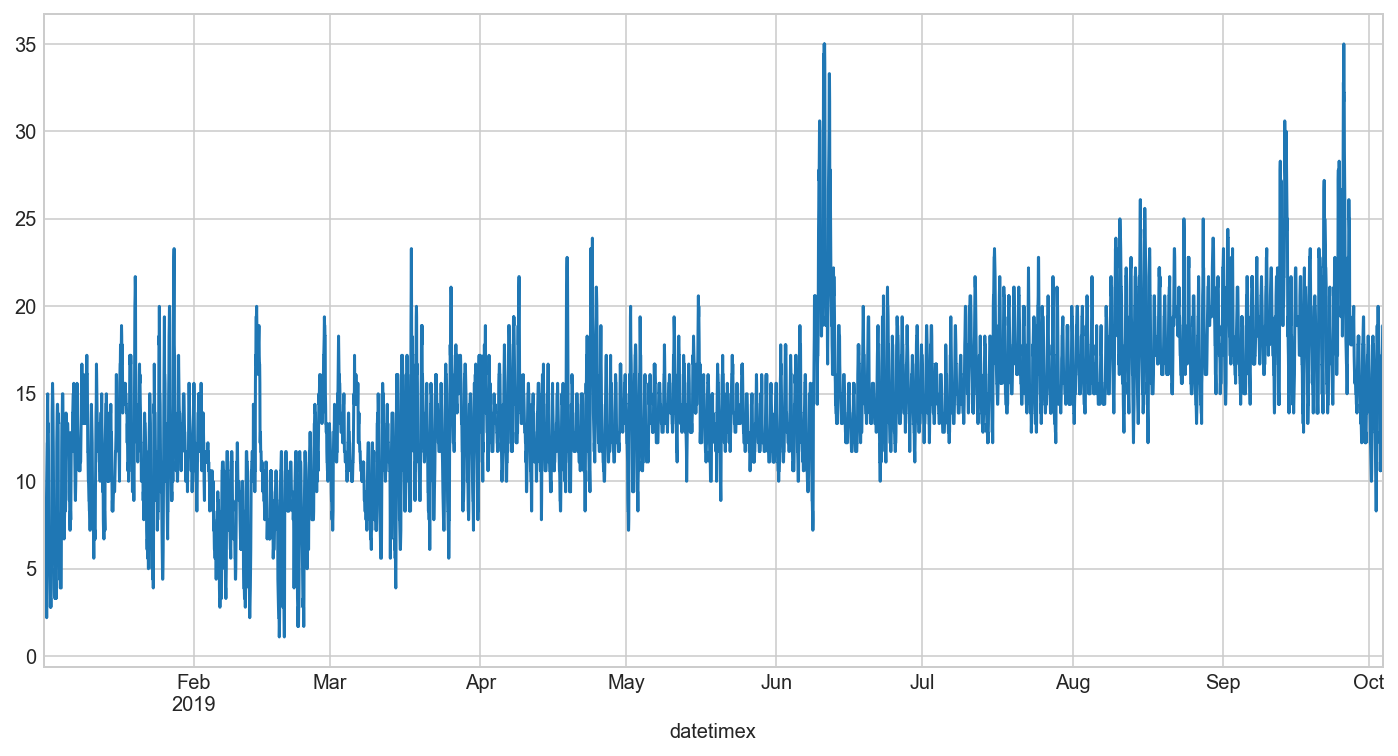

In [43]:
plt.figure(figsize=(12, 6))
sta_1.tempC.plot()

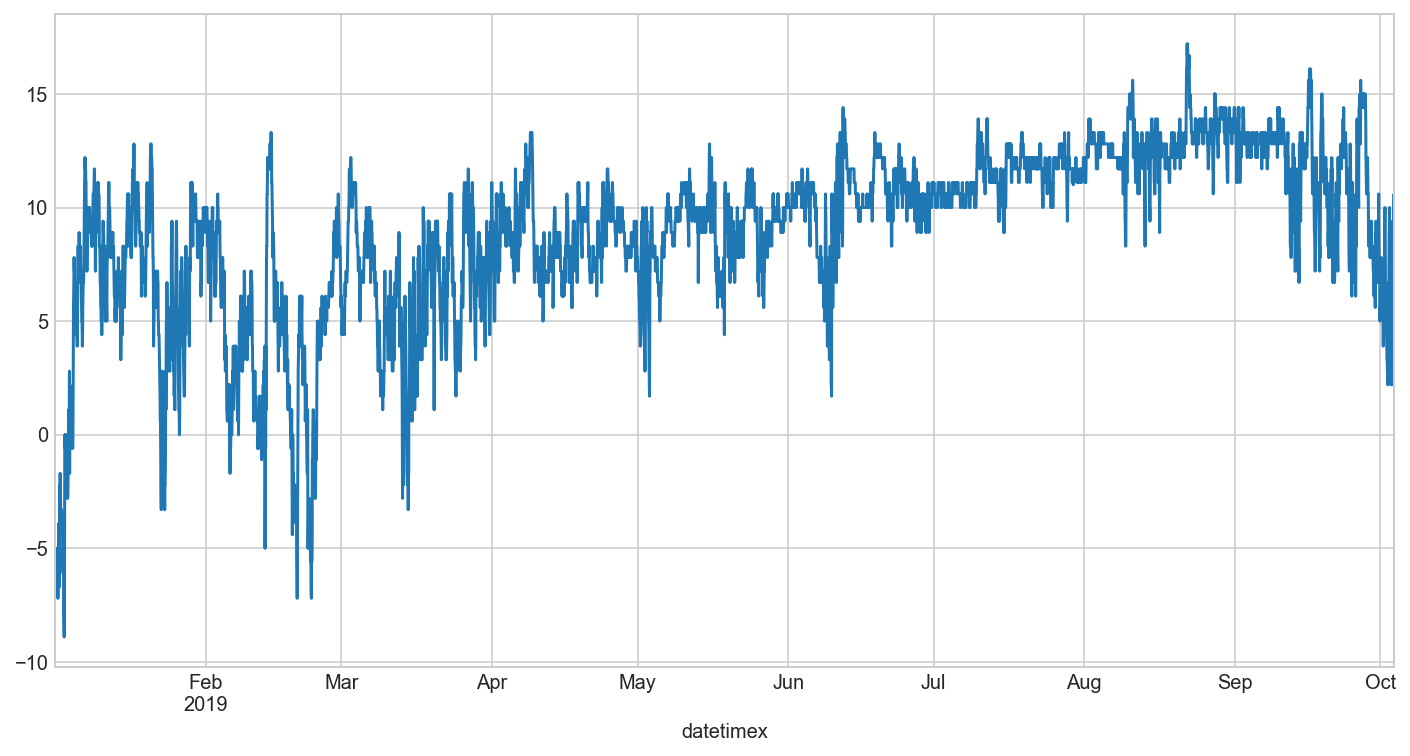

In [44]:
plt.figure(figsize=(12, 6))
sta_1.dewC.plot()

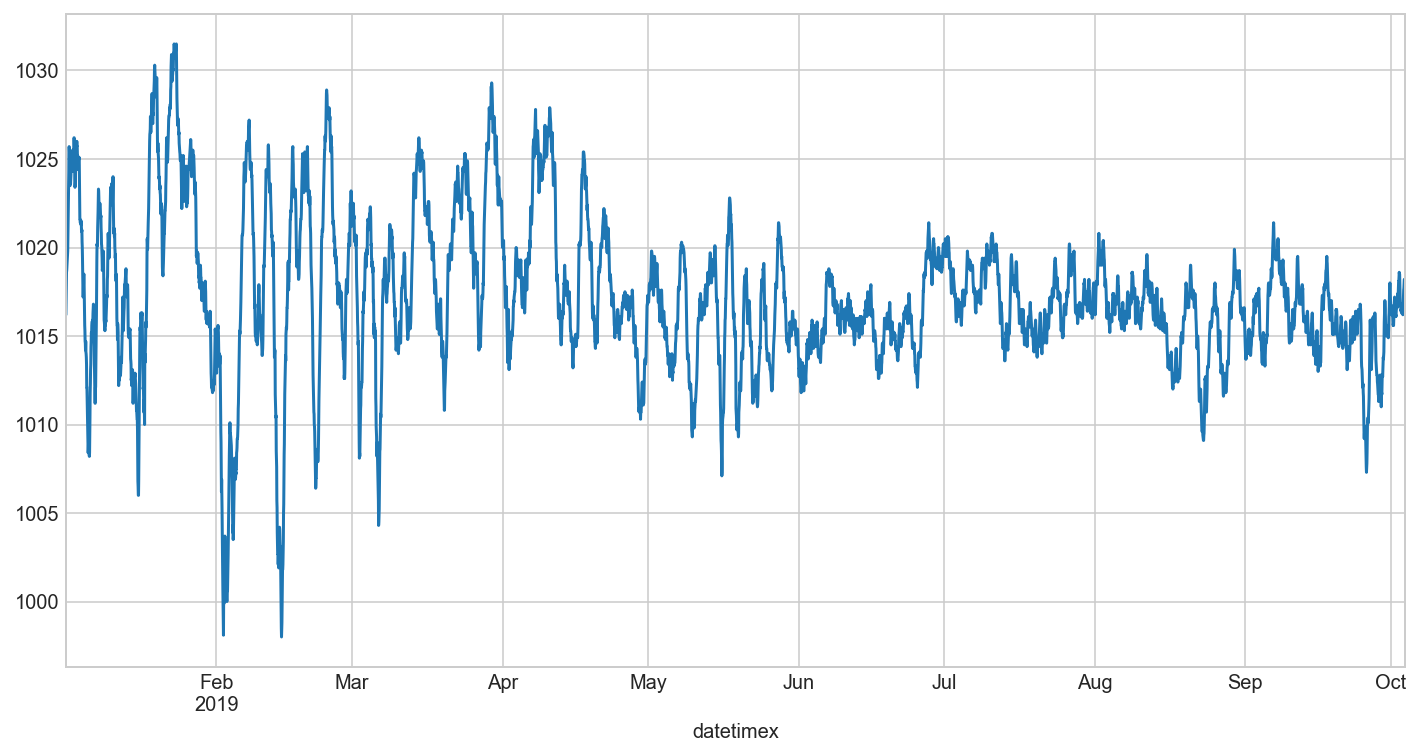

In [45]:
#[ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']
plt.figure(figsize=(12, 6))
sta_1.preshPa.plot()

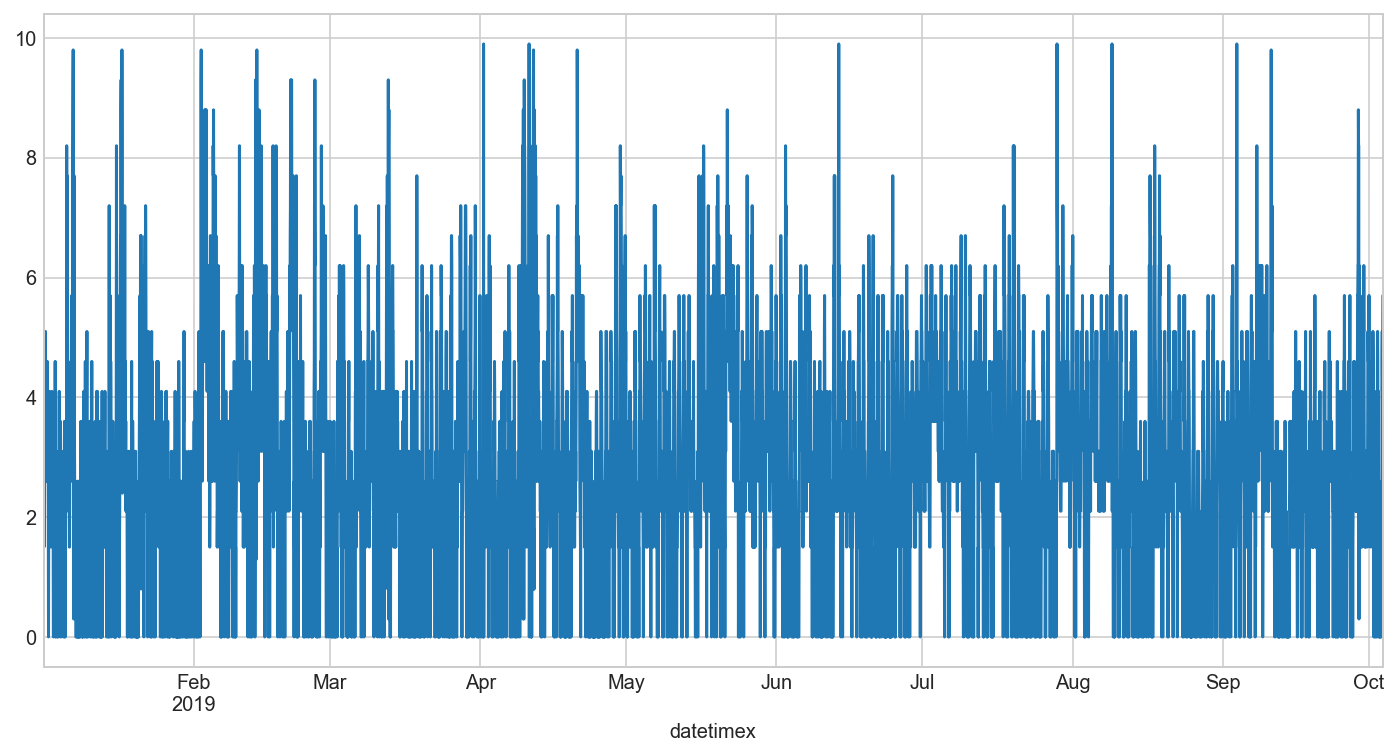

In [46]:
#[ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']
plt.figure(figsize=(12, 6))
sta_1.windMtPs.plot()

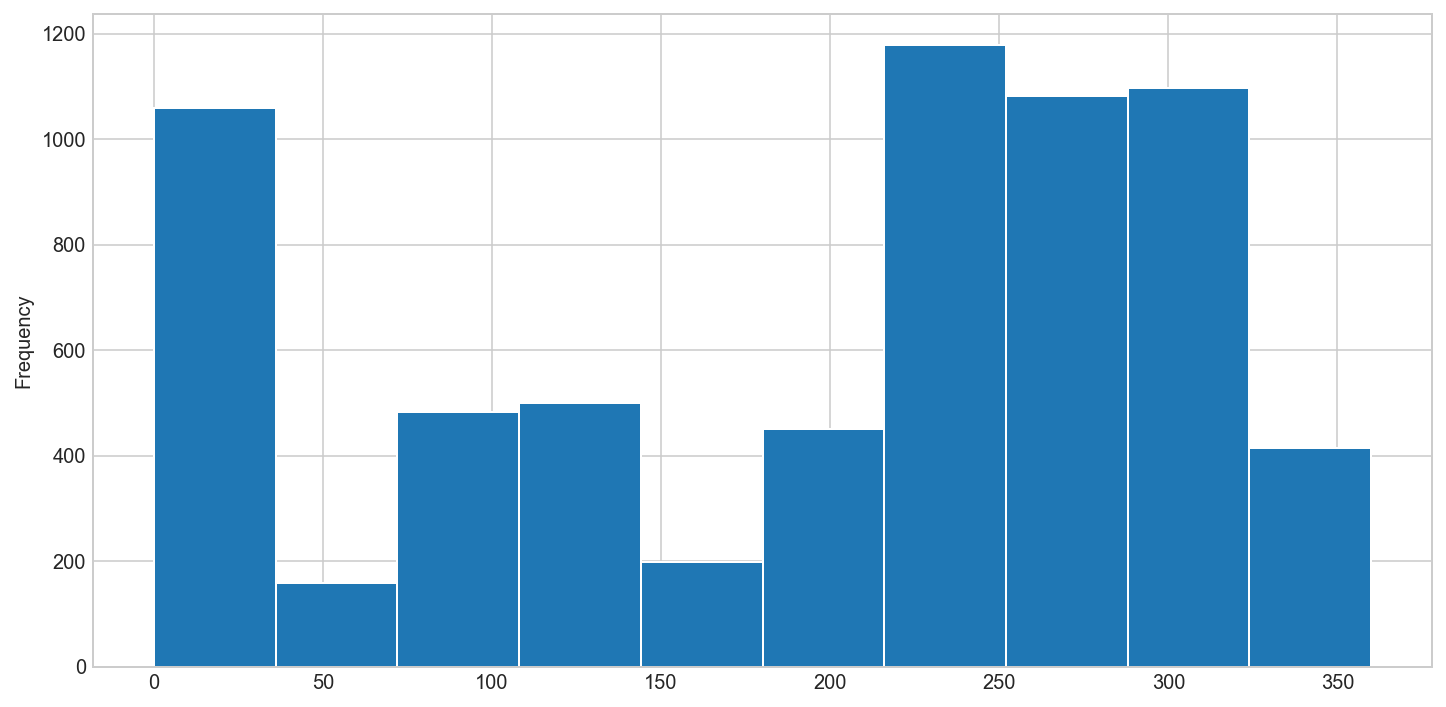

In [47]:
#[ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']
plt.figure(figsize=(12, 6))
sta_1.windAz.plot(kind='hist')

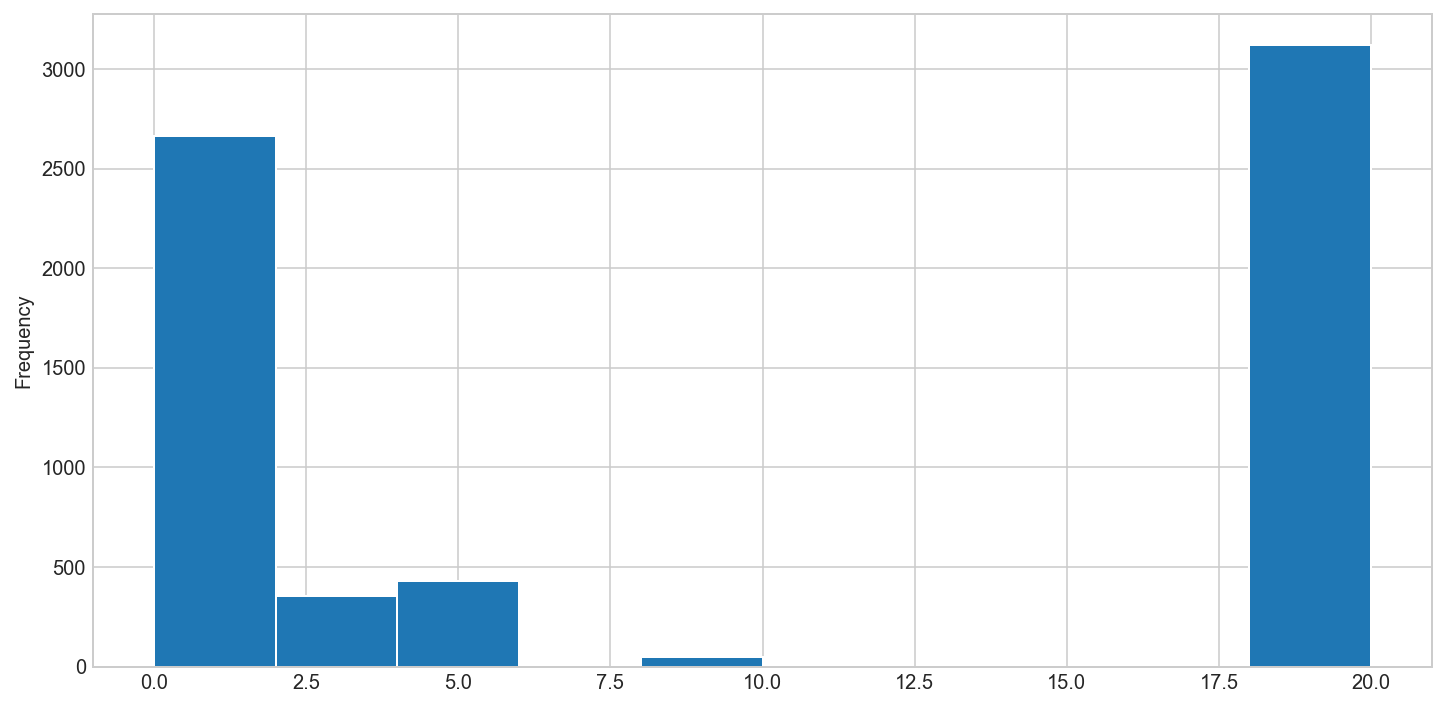

In [48]:
#[ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']
plt.figure(figsize=(12, 6))
sta_1.skyCode.plot(kind='hist')

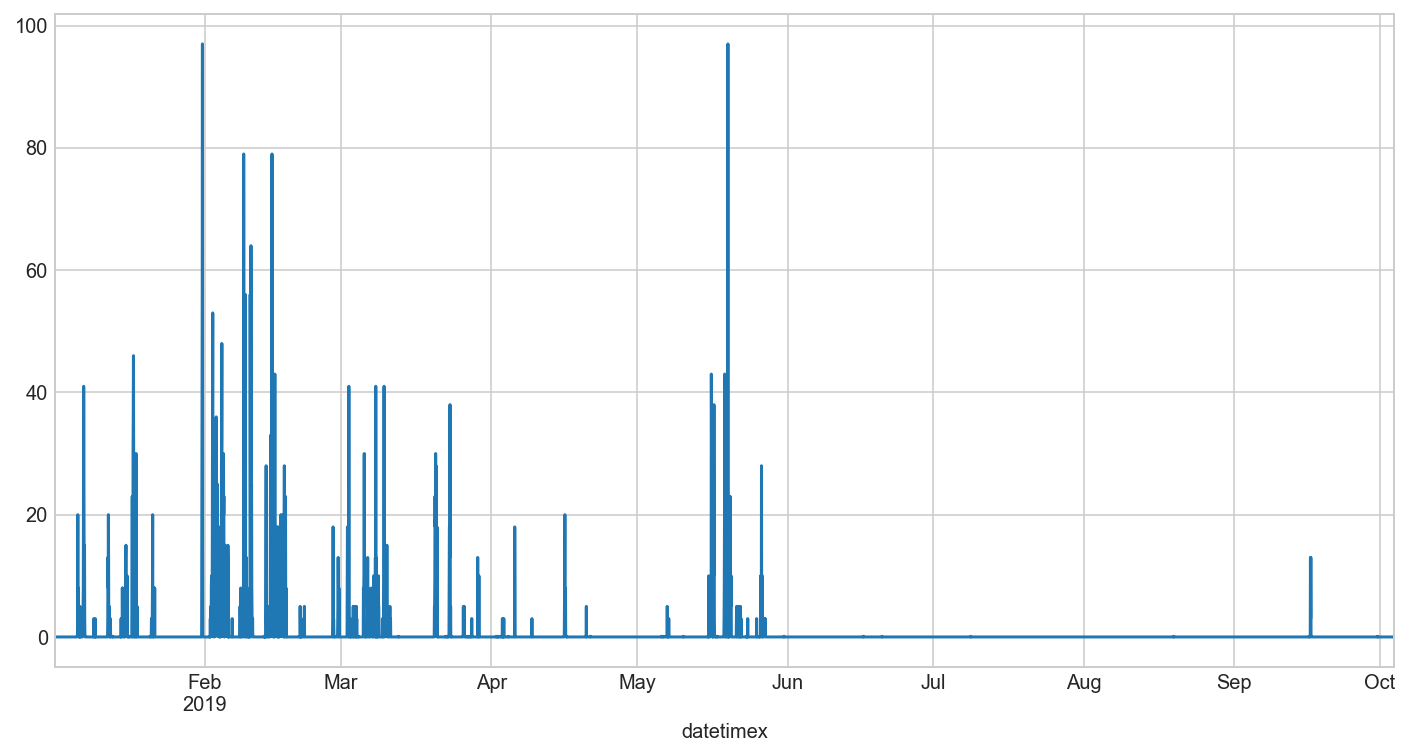

In [49]:
#[ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']
plt.figure(figsize=(12, 6))
sta_1.precip1hr.plot()

In [50]:
print("-------null values for Station 1--------")

display(sta_1[sta_1.isnull()].count())
print("------- -9999 values for Station 1--------")
display(sta_1[sta_1 == -9999].count())
print("-----for comparison, this station -9999 values")
dfs["Sta_724915_23259"][dfs["Sta_724915_23259"]==-9999].count()

print("------- temperature and dew point 999 values for Station 1--------")
display(sta_1[sta_1 == 999].count())
dfs["Sta_724915_23259"][dfs["Sta_724915_23259"]==999].count()

-------null values for Station 1--------


tempC        0
dewC         0
preshPa      0
windMtPs     0
windAz       0
skyCode      0
precip1hr    0
precip6hr    0
dtype: int64

------- -9999 values for Station 1--------


tempC        0
dewC         0
preshPa      0
windMtPs     0
windAz       0
skyCode      0
precip1hr    0
precip6hr    0
dtype: int64

-----for comparison, this station -9999 values
------- temperature and dew point 999 values for Station 1--------


tempC        0
dewC         0
preshPa      0
windMtPs     0
windAz       0
skyCode      0
precip1hr    0
precip6hr    0
dtype: int64

year          0
month         0
day           0
hour          0
tempC10       1
dewC10        1
preshPa10     0
windDeg       0
windMtPs10    0
skyCode       0
precip1hr     0
precip6hr     0
dtype: int64

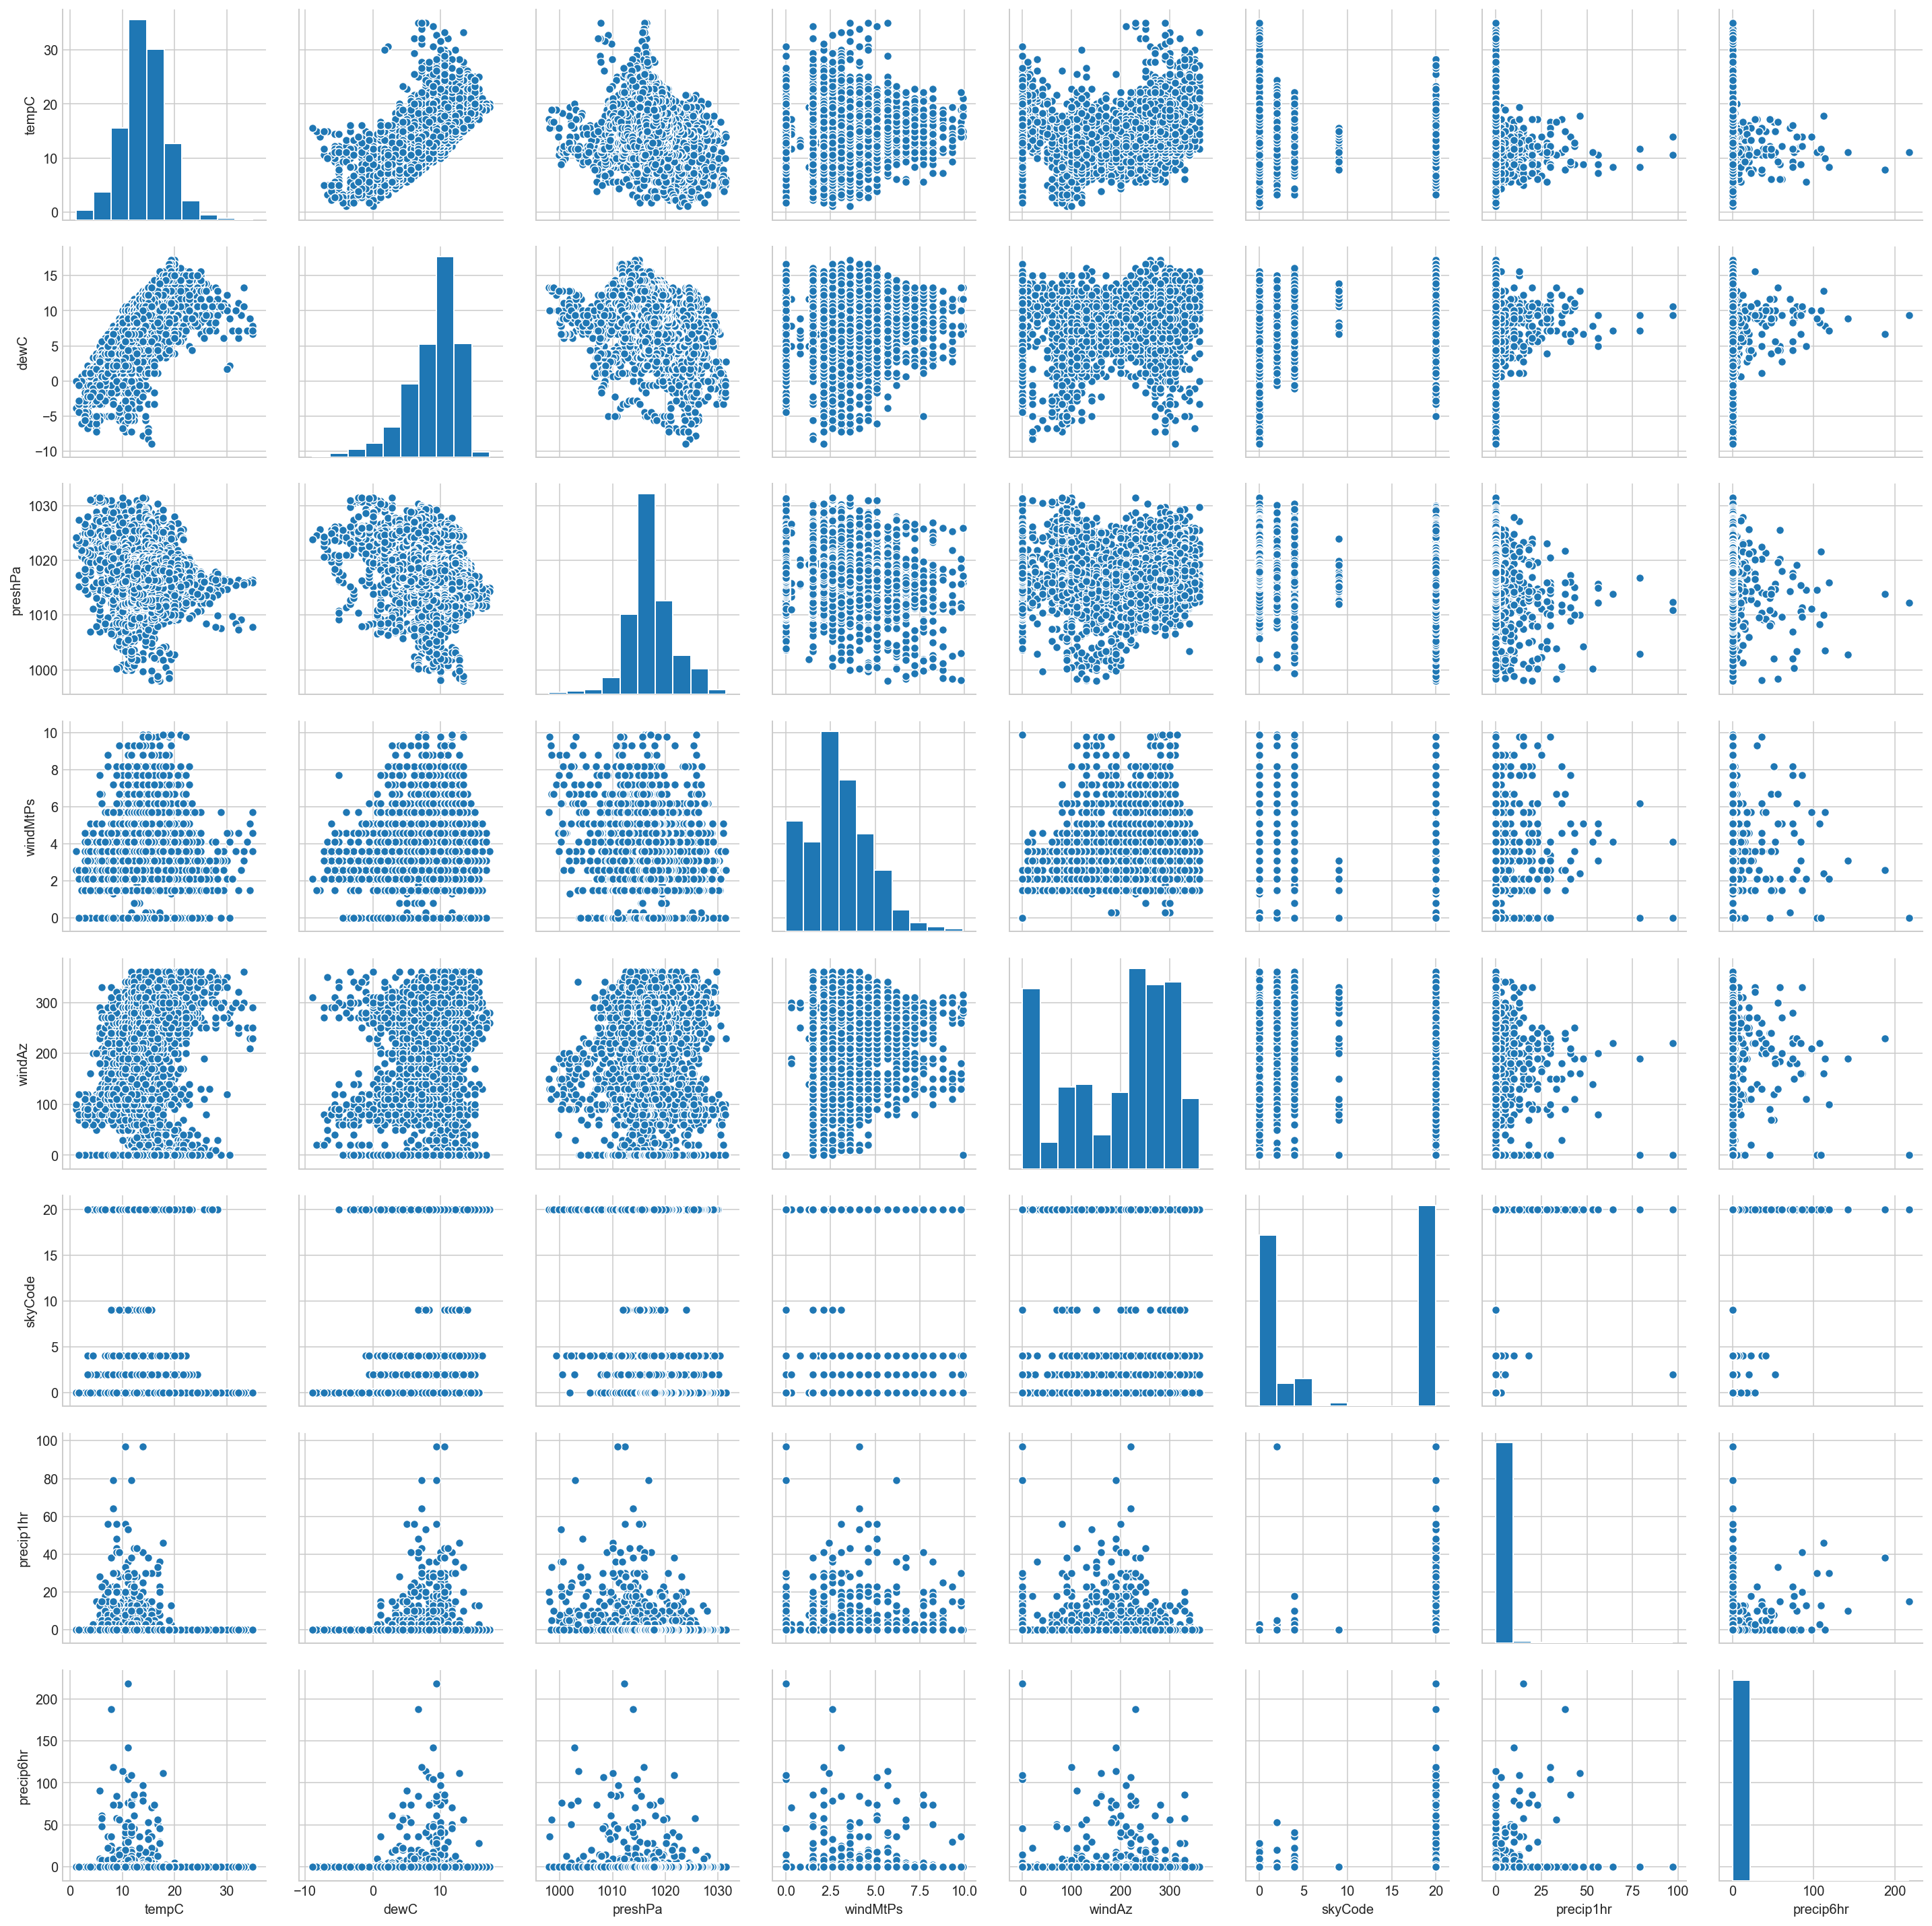

In [51]:
sns.pairplot(sta_1)

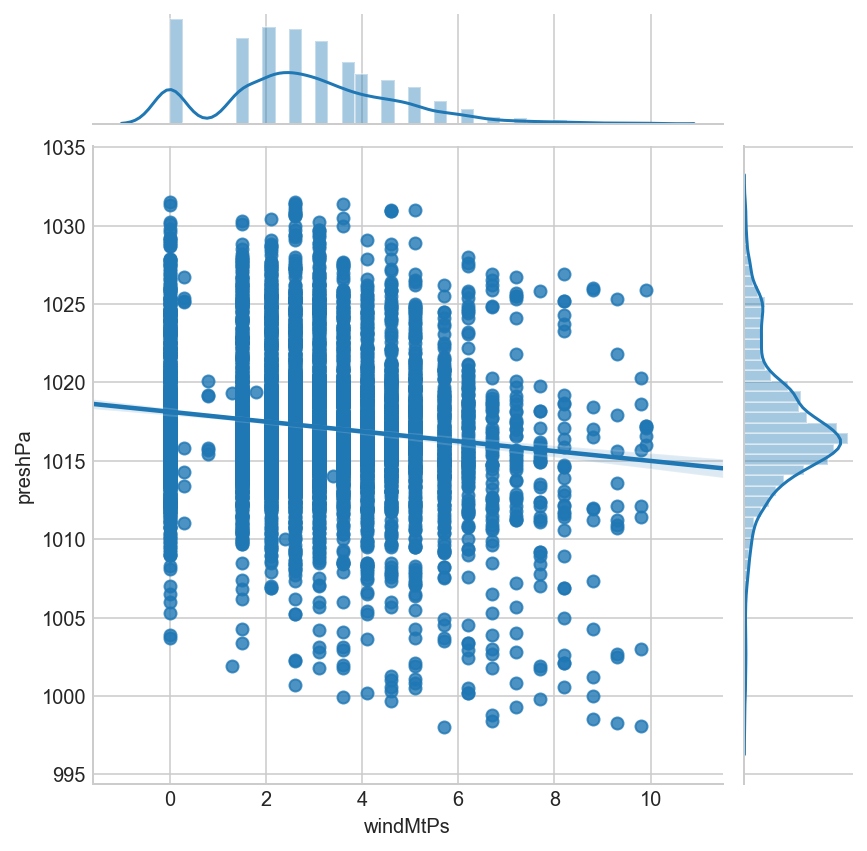

In [55]:
sns.jointplot(sta_1.windMtPs,sta_1.preshPa,kind="reg")

4.071979901316475
4.260763250619939


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              precip1hr   R-squared (uncentered):                   0.063
Model:                            OLS   Adj. R-squared (uncentered):              0.062
Method:                 Least Squares   F-statistic:                              51.70
Date:                Thu, 17 Oct 2019   Prob (F-statistic):                    6.74e-62
Time:                        21:01:16   Log-Likelihood:                         -13121.
No. Observations:                4635   AIC:                                  2.625e+04
Df Residuals:                    4629   BIC:                                  2.629e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tempC         -0.1273      0.022     -5.775      0.000      -0.171      -0.084
dewC           0.0723      0.025      2.940      0.003       0.024       0.121
preshPa        0.0011      0.000      4.764      0.000       0.001       0.002
windMtPs       0.3288      0.041      7.958      0.000       0.248       0.410
windAz        -0.0038      0.001     -5.382      0.000      -0.005      -0.002
skyCode        0.0482      0.007      6.857      0.000       0.034       0.062
==============================================================================
Omnibus:                     8194.733   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9424136.203
Skew:                          12.568   Prob(JB):                         0.00
Kurtosis:                     222.468   Cond. No.                         719.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

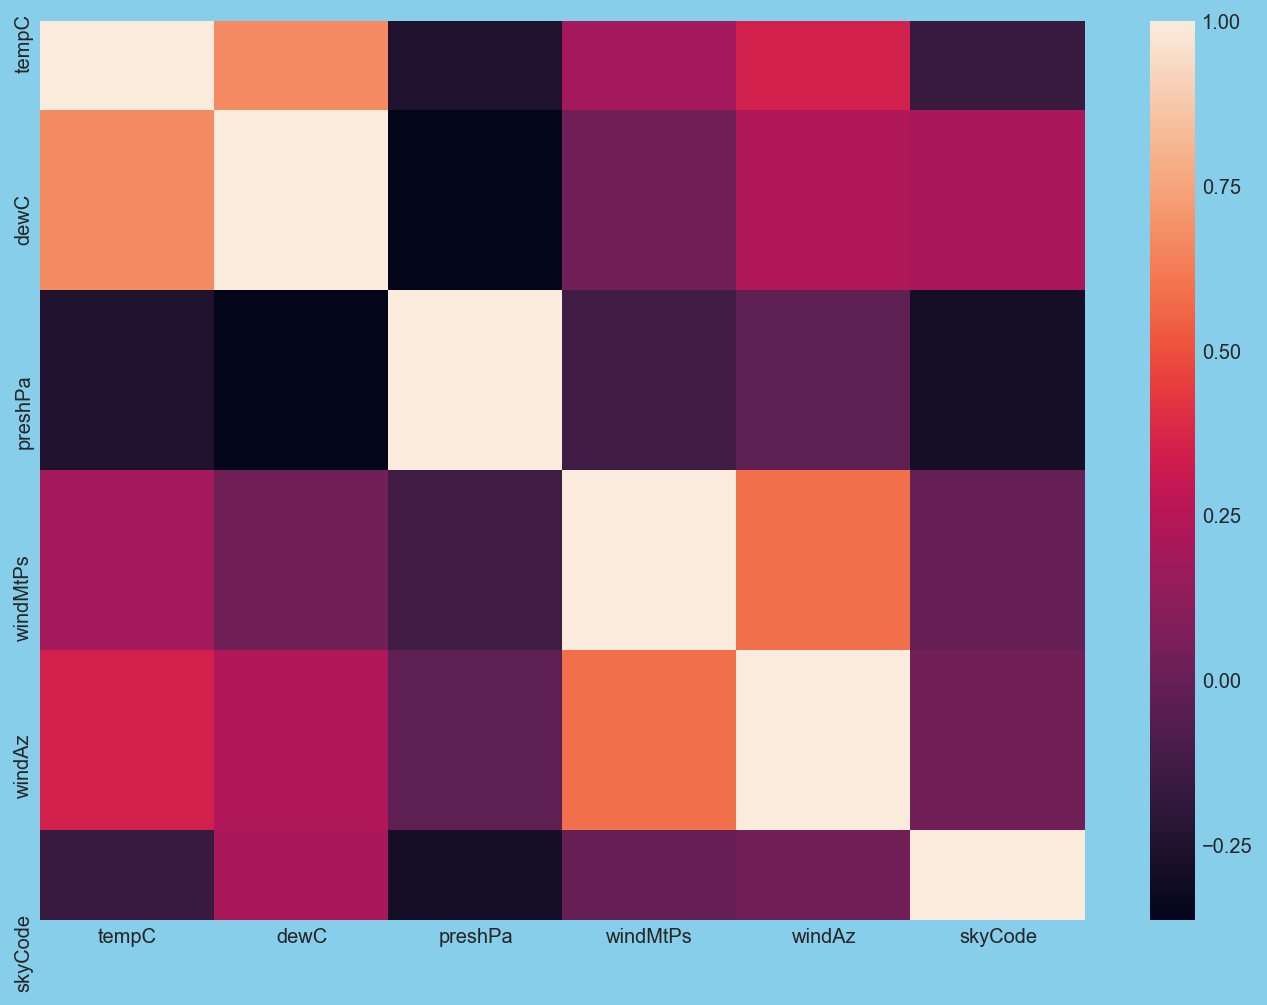

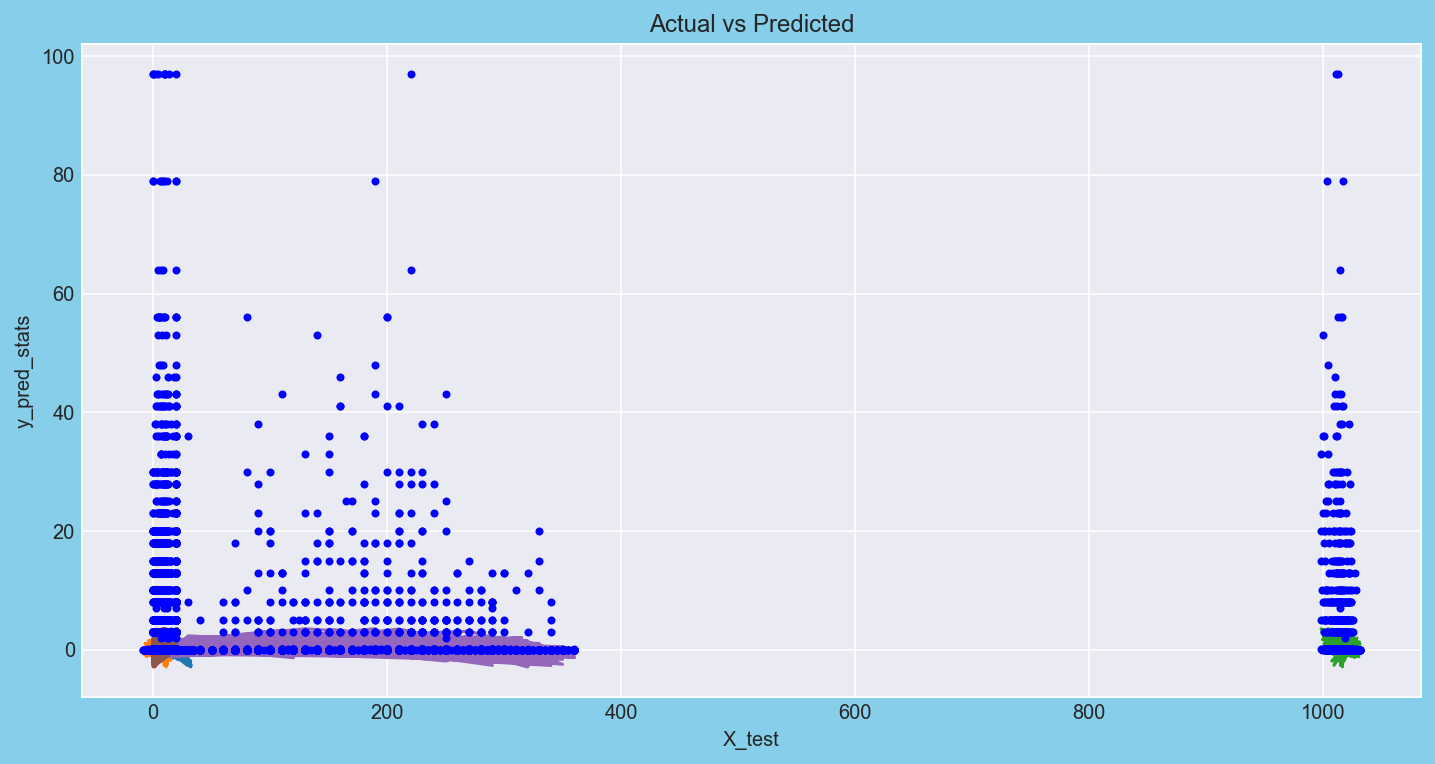

In [56]:
import statsmodels.api as sm
import warnings
warnings.simplefilter("ignore")
from sklearn import datasets  
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import patsy
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_style('darkgrid', {'figure.facecolor':'skyblue'})
# Set some Pandas options
pd.set_option('max_columns', 140)
pd.set_option('max_rows', 140)

X_col = [ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode']
 
col_all =  [ 'tempC', 'dewC', 'preshPa', 'windMtPs', 'windAz', 'skyCode', 'precip1hr', 'precip6hr']
 
y_col =[ 'precip1hr']

X = sta_1[X_col] 
y = sta_1[y_col]

#y, X = patsy.dmatrices("tempC10 ~ AGE + RM", data=sta_df, return_type="dataframe")

 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=.30)

lr = LinearRegression()
lr.fit(X_train, y_train)   # sklearn Linear Regression Model
y_pred = lr.predict(X_test) # make predictions using sklearn model
 



model = sm.OLS(y_train, X_train).fit() #stats model, linear regression...
y_pred_stats = model.predict(X_test) # make the predictions using stats Linear Regression model


#Training RMSE 
print(np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train)  )))
#Testing RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_stats)))

# Print out the statistics
display(model.summary())

a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
corr = X.corr()
sns.heatmap( corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax=ax)

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(X_test, y_pred_stats)     # regression line
plt.plot(X, y, 'b.')   # scatter plot showing actual data
plt.title('Actual vs Predicted')
plt.xlabel('X_test')
plt.ylabel('y_pred_stats')

plt.show()

#### Remaining Work?
- concatenate into 1 time series index
- append lat/long
- map and select new stations
- run analysis for better interpolation as Matt described...